In [1]:
# To verify that there is an access to the GPU
!nvidia-smi

Fri May 19 09:35:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Setup and imports

In [2]:
import torch
import cv2
print(f"GPU device is available : {torch.cuda.is_available()}")

GPU device is available : True


In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
from tqdm.auto import tqdm
from IPython import display
from IPython.display import Image

In [4]:
HOME = "/content"

if not os.path.isdir(f"{HOME}/weights"):
    os.mkdir(f"{HOME}/weights")

if not os.path.isdir(f"{HOME}/data"):
    os.mkdir(f"{HOME}/data")

Installation of YOLOv8 (You Only Look Once) and its dependencies

In [5]:
!pip install ultralytics

display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.105 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


Download the default weights of the nano YOLO model

In [6]:
from ultralytics import YOLO

yolo_model = YOLO(f'{HOME}/weights/yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 80.6MB/s]


Installation of Segment Anything Model (SAM) and other dependencies

In [7]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tt3tyd5p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tt3tyd5p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=f106f772441ca37c866b282fe595bfdcd4d9e103c9e5927070bb0b8cb98772d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_gxtppn/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


Download the default pretrained weights of the SAM 

In [8]:
if not os.path.isfile(f"{HOME}/weights/sam_vit_h_4b8939.pth"):
    %cd {HOME}/weights
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_WEIGHTS_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"

/content/weights


Loading the SAM model

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_model = sam_model_registry["vit_h"](checkpoint=SAM_WEIGHTS_PATH).to(device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

Downloading supervision library from roboflow for a simpler displaying

In [10]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

import supervision as sv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00


Downloading a image exmaple

In [11]:
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg

/content/data


# 2. Exploration of YOLO capabilities : object detection and classification with bounding boxes

In [12]:
IMAGE_NAME = "dog.jpeg"  # replace with your image name if you have downloaded yours
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [13]:
%cd {HOME}
_ = yolo_model.predict(IMAGE_PATH, imgsz=640, conf=0.25, save=True)

/content



image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 64.5ms
Speed: 14.3ms preprocess, 64.5ms inference, 60.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


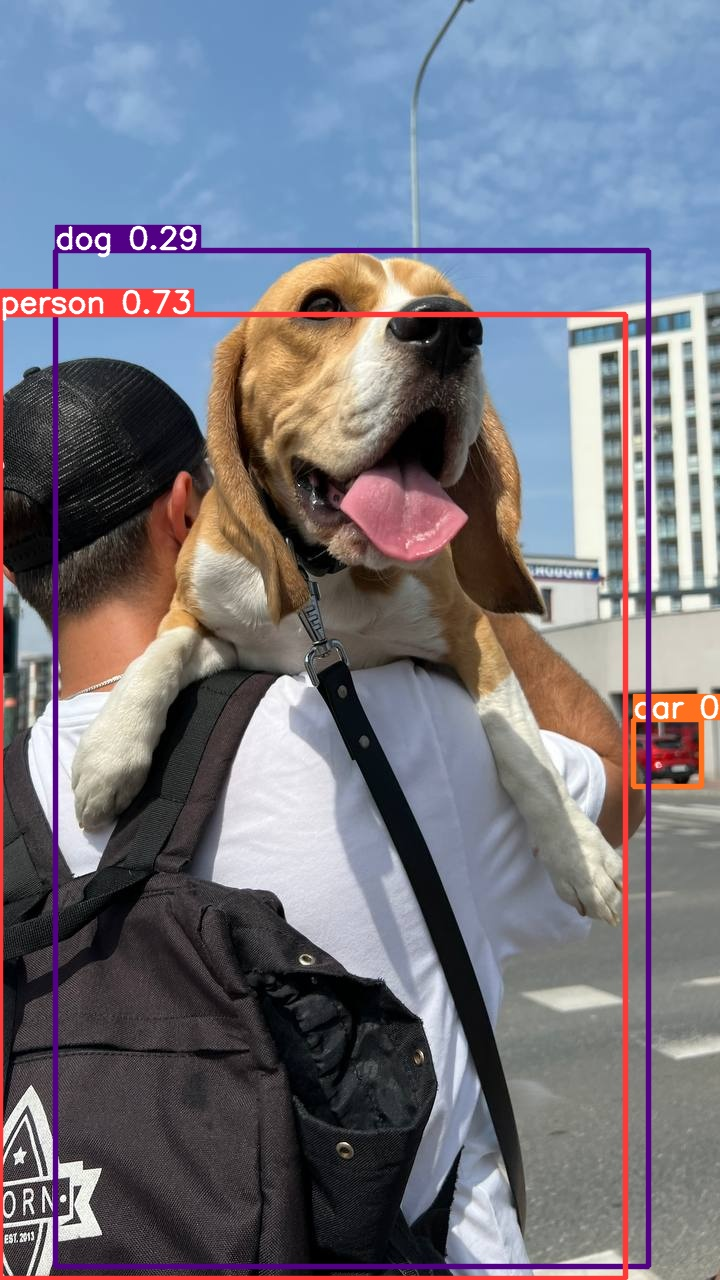

In [14]:
Image(filename='runs/detect/predict/dog.jpeg', height=600)

# 3. Exploration of SAM capabilities : mask generator

## 3.1 Automatic mask generator

Creates a mask_generator by providing a SAM model to the `SamAutomaticMaskGenerator`class. In our case, we provide the default sam model imported in the previous cell.

In [15]:
mask_generator = SamAutomaticMaskGenerator(sam_model)

In [16]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

Using supervision to easily display the different masks

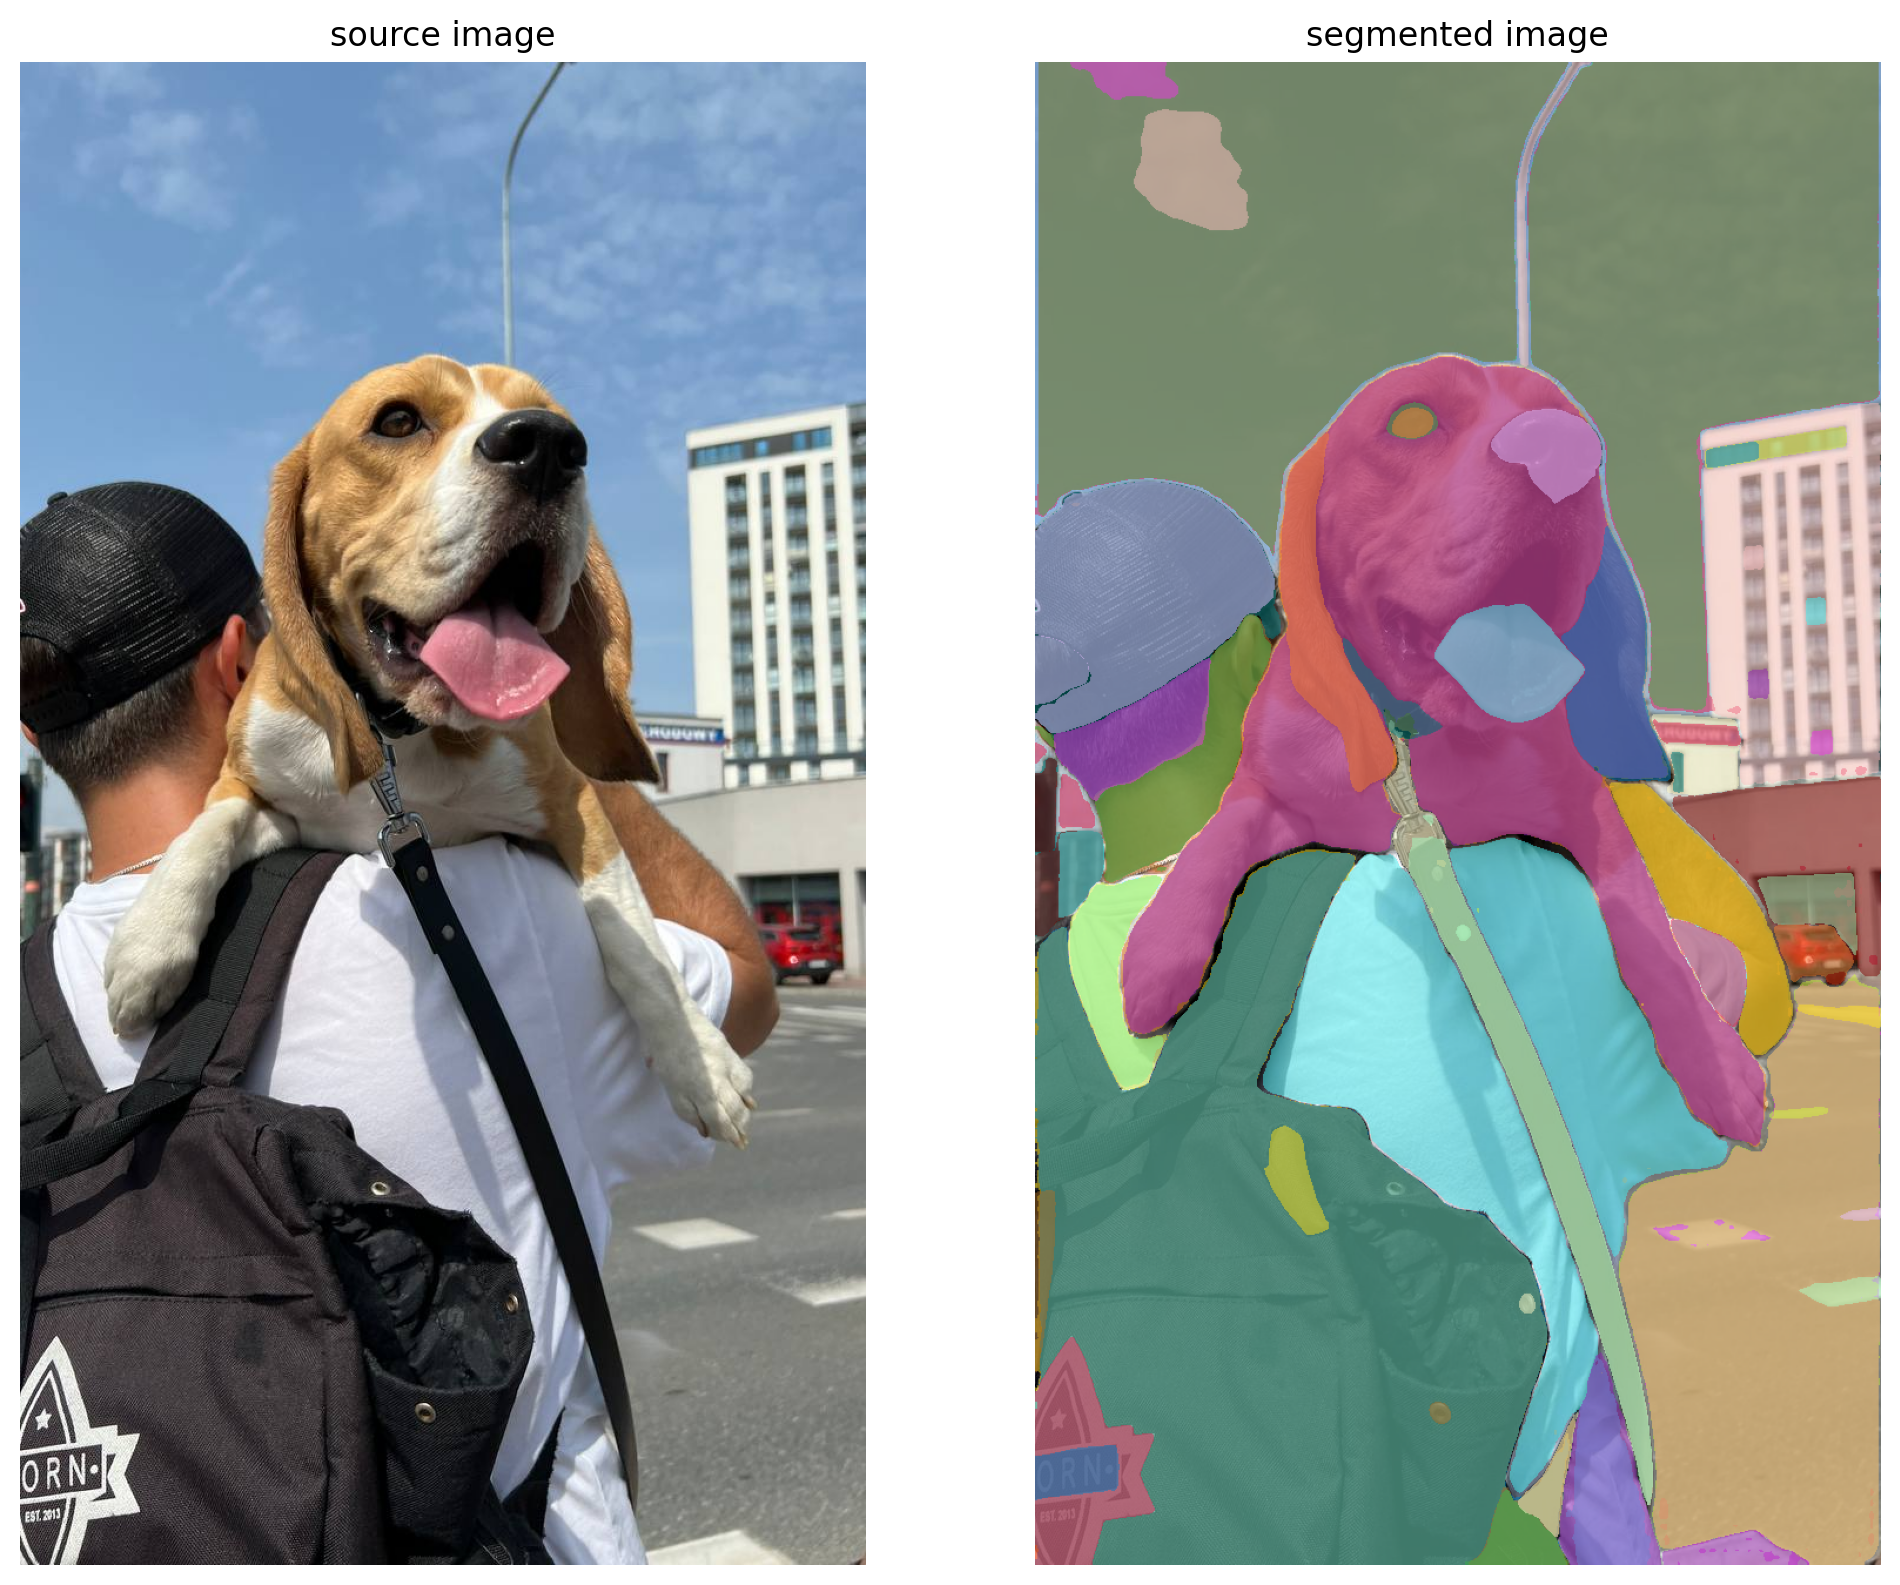

In [17]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

Segmentation results : masks generated by SAM

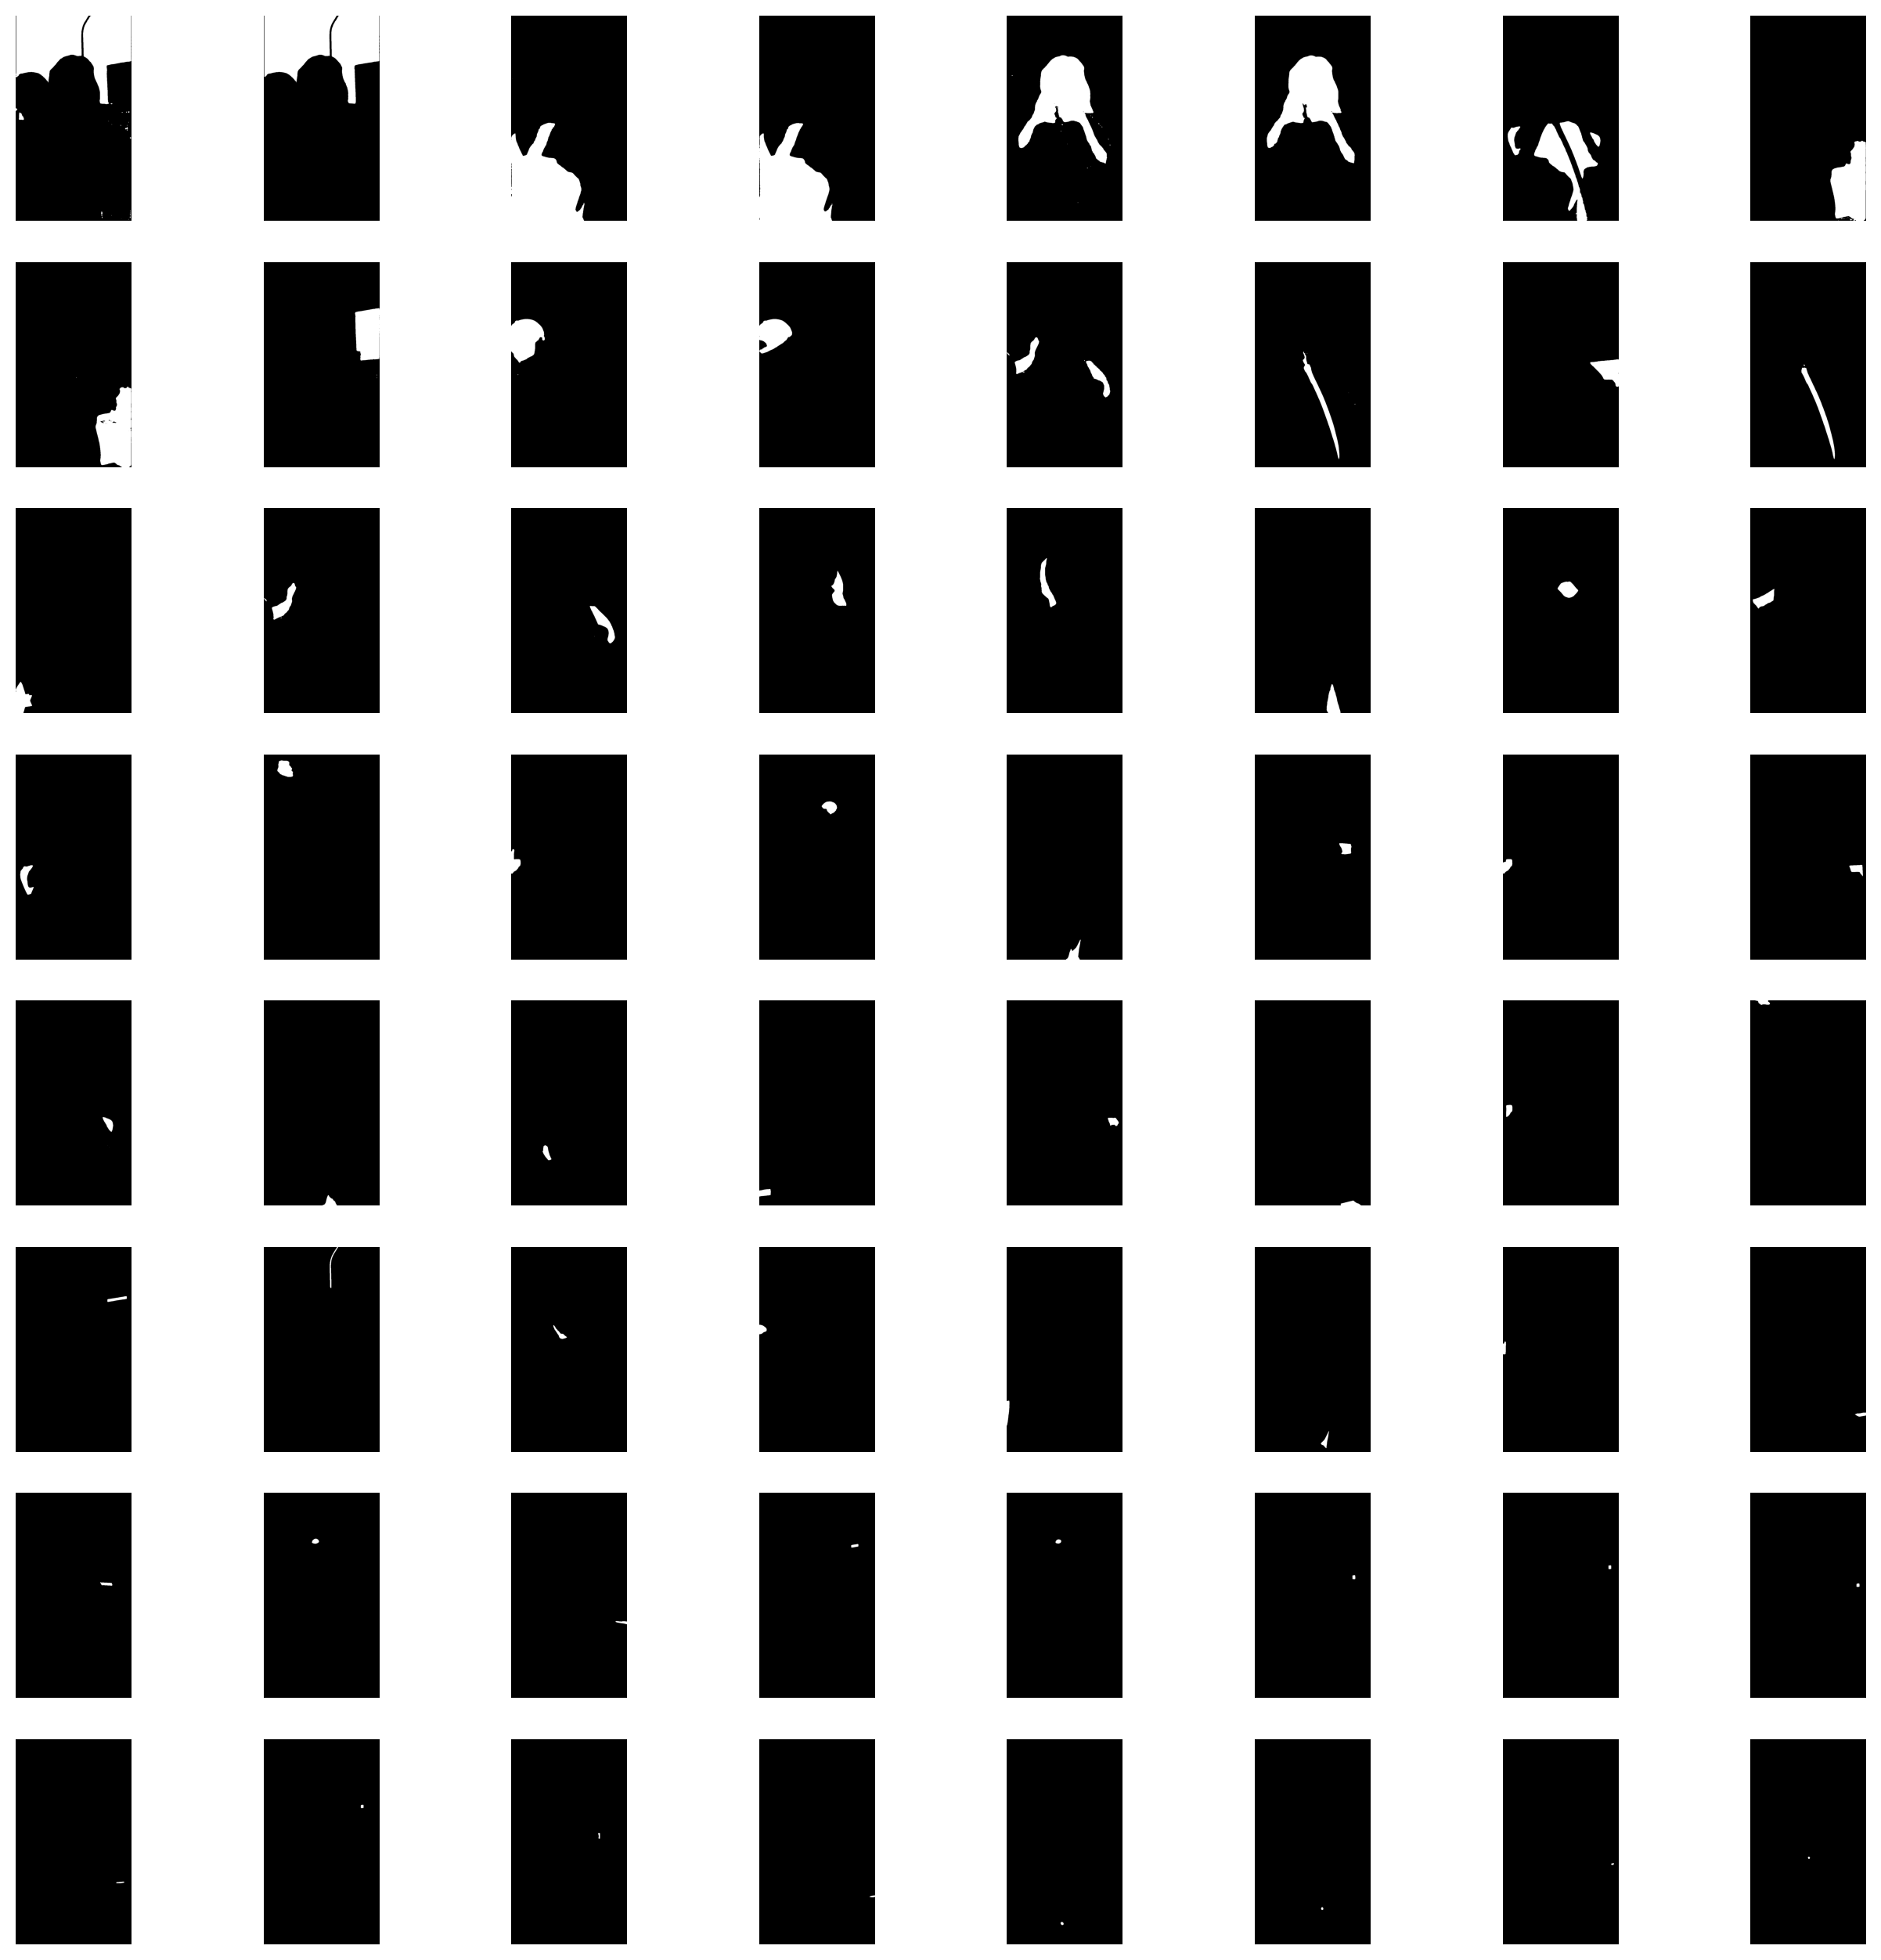

In [18]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

So, as states in its name, SAM model is capable of segementing anything. But, if you want it to segement specific parts of an image, you need to give it indications : whether a point, a bounding box or a segementation line.

So for example we could give SAM model the bounding boxes inferred by YOLOv8. 

## 3.2 Drawing bounding boxes to vizualize how SAM works

In [19]:
mask_predictor = SamPredictor(sam_model)

# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [20]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [25]:
widget.bboxes

[{'x': 65, 'y': 235, 'width': 572, 'height': 702, 'label': ''}]

In [22]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Visualize results with Supervision

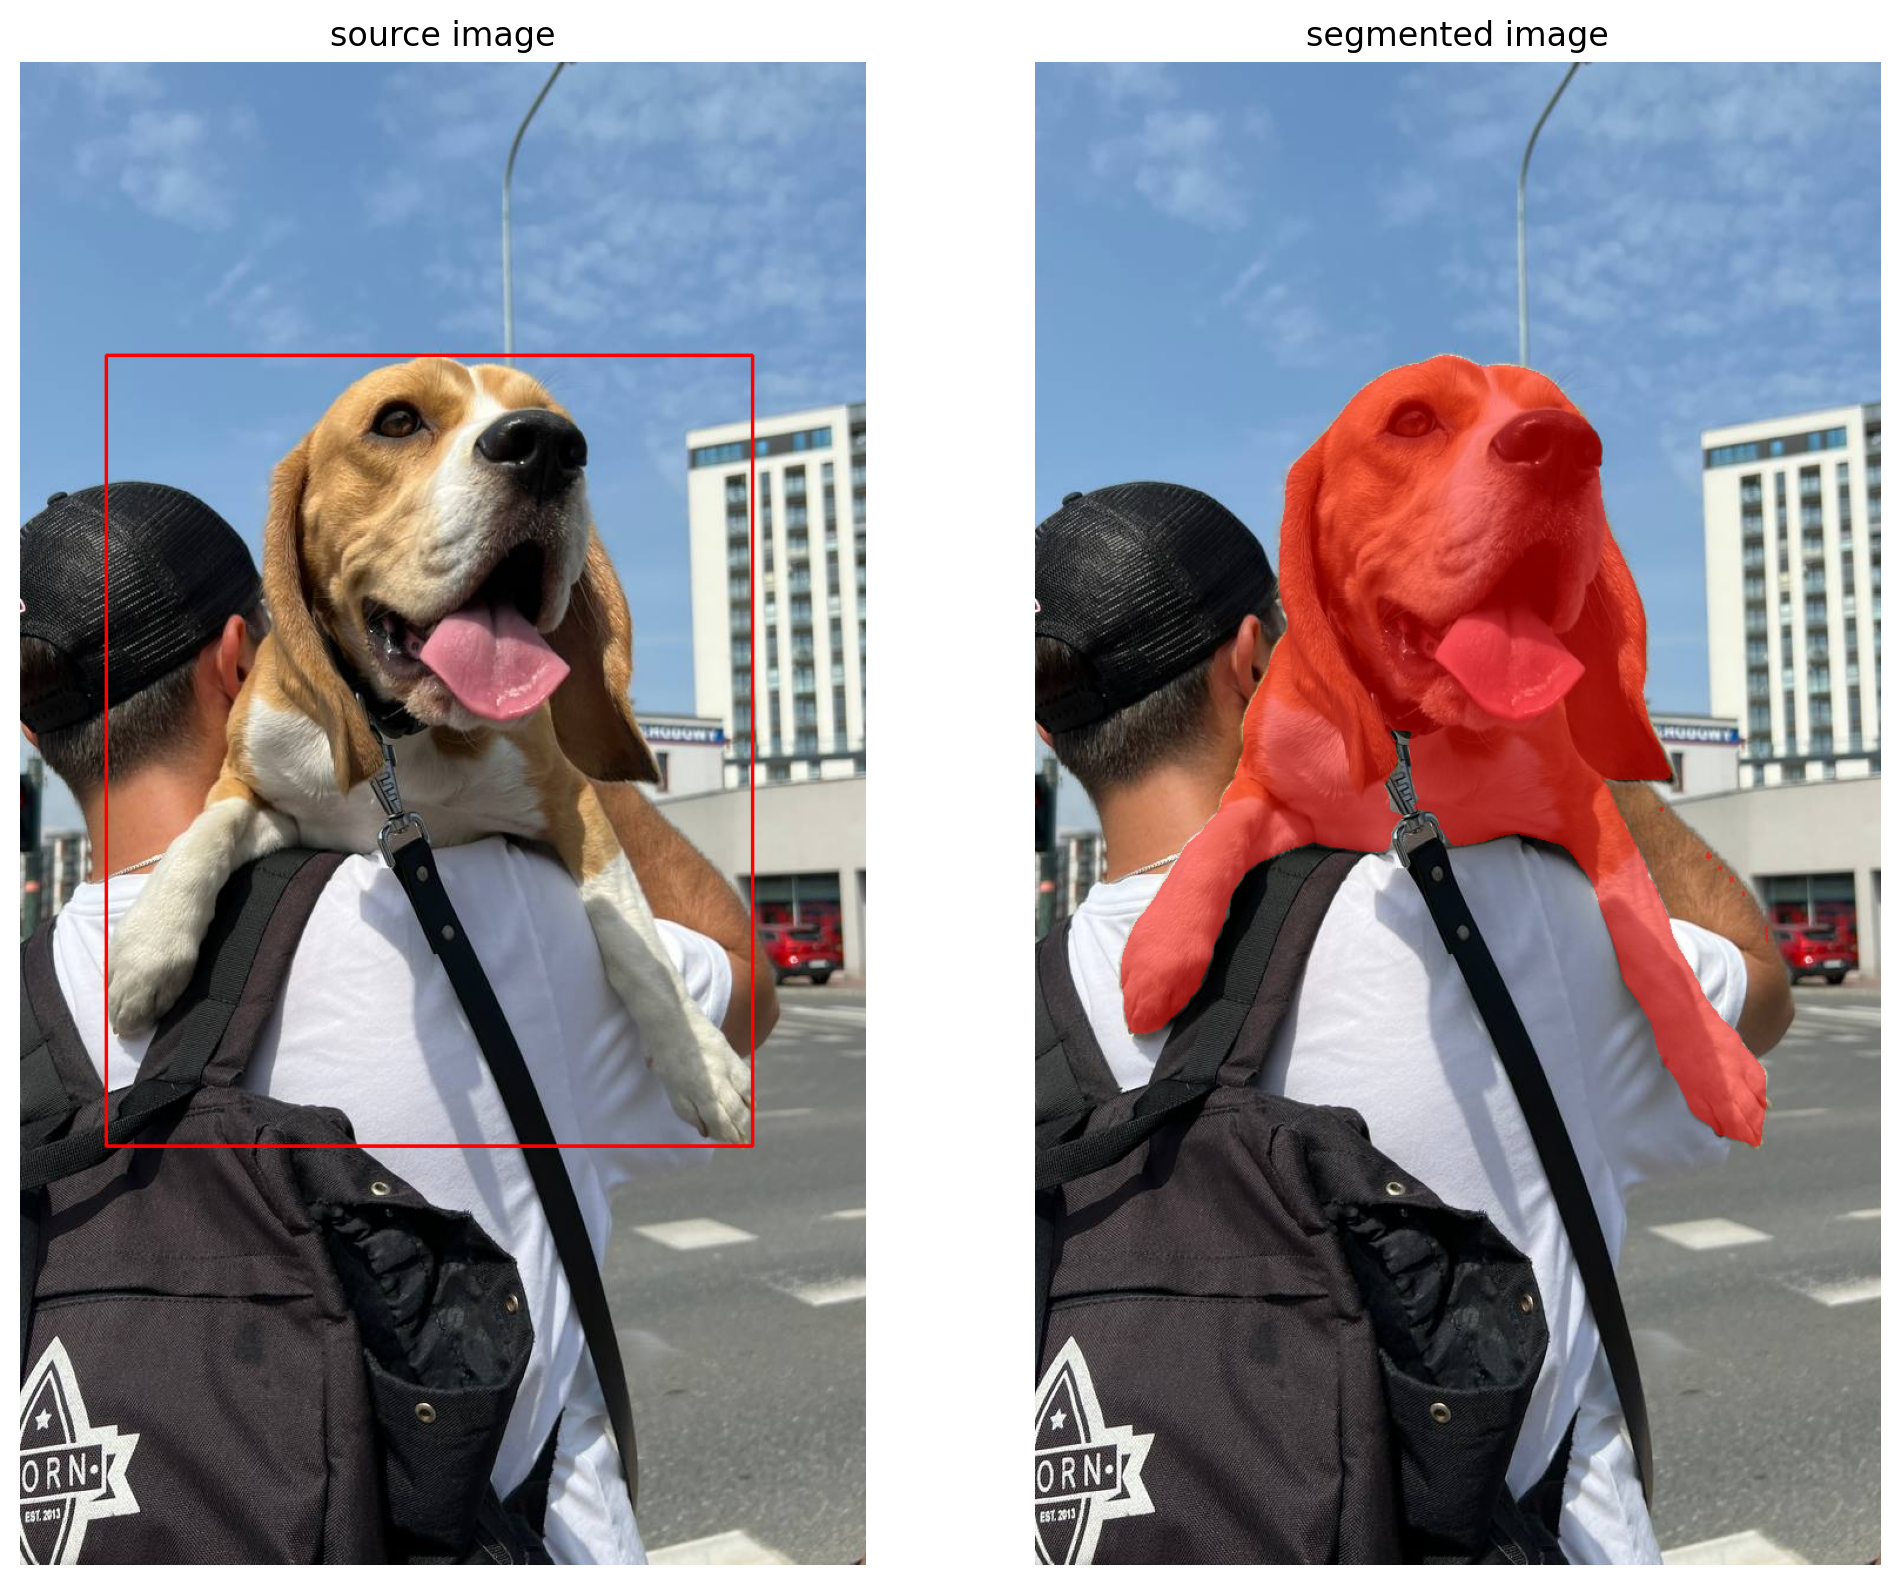

In [23]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

Segmentation results : masks generated by SAM

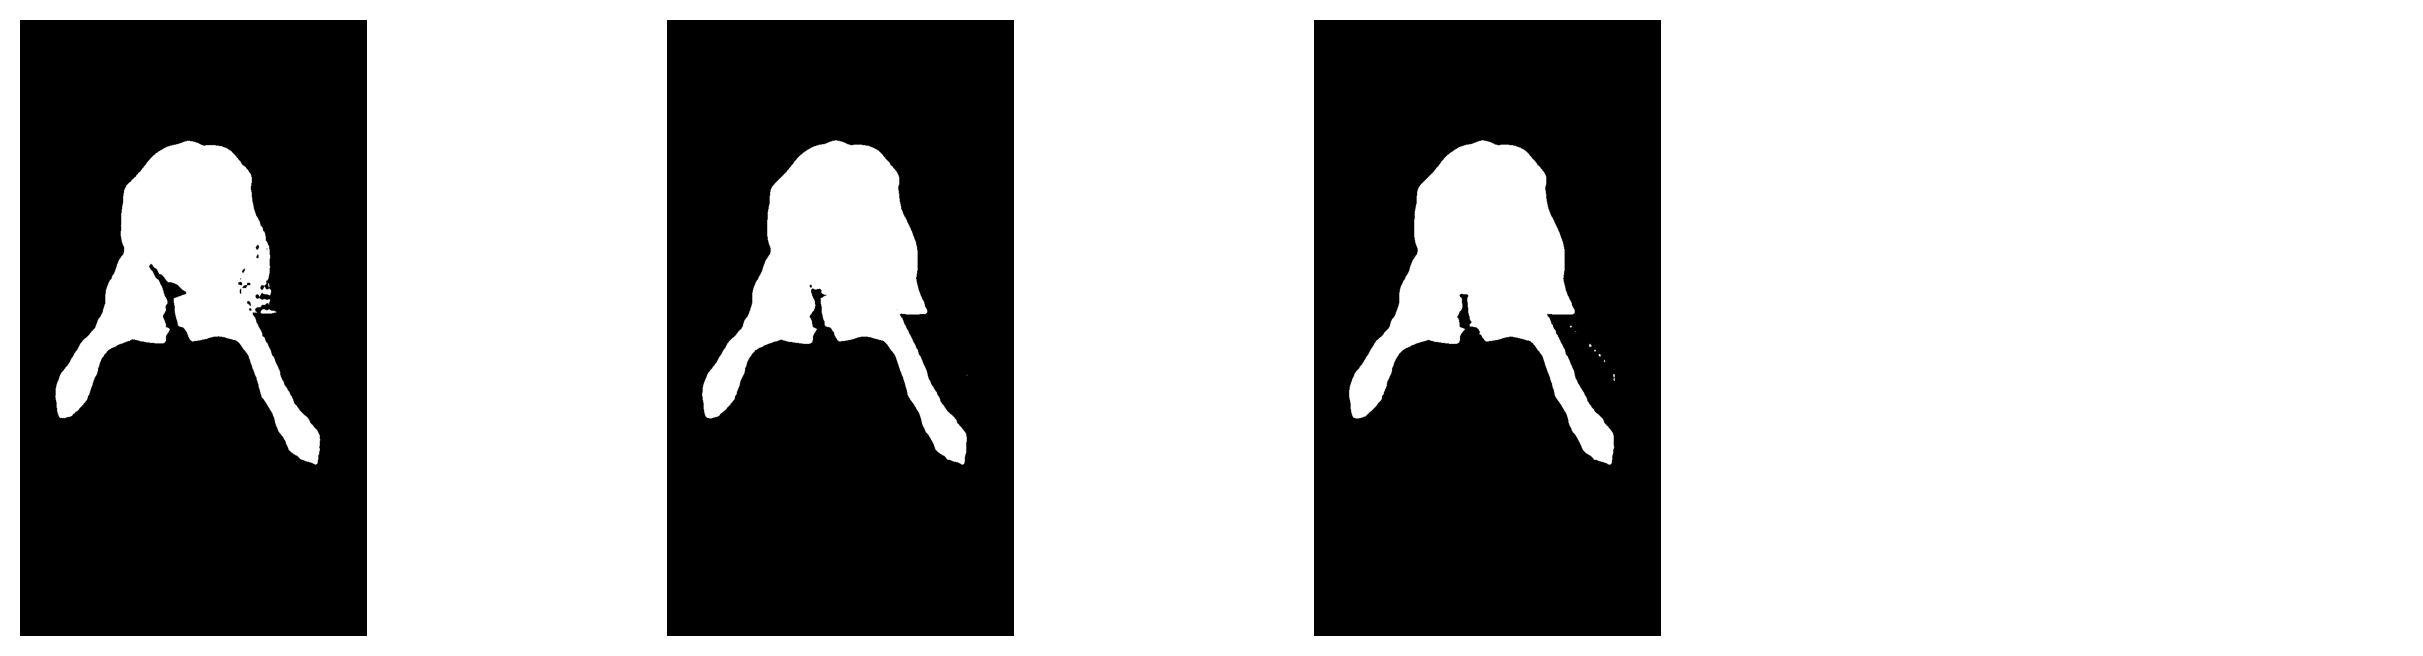

In [24]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)